# Analysis of the MNIST results

In [15]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import math
import scienceplots 


from scipy.stats import spearmanr
import matplotlib as mpl

mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['mathtext.fontset'] = 'dejavusans'


Load results. The results should be in aggregated form. Run "data_collection_winequality" to obtain the aggregated results.

In [16]:
def load_results(pickle_path):
    """Load dict from pickle file. 
    """
    with open(pickle_path, 'rb') as f:
            return pickle.load(f)


In [17]:
complexity = load_results("results_final_mnist/aggregated/complexity_aggregated.pkl")
determinism = load_results("results_final_mnist/aggregated/determinism_aggregated.pkl")
featureflipping = load_results("results_final_mnist/aggregated/feature_flipping_aggregated.pkl")
ris = load_results("results_final_mnist/aggregated/relative_input_stability_aggregated.pkl")
rri = load_results("results_final_mnist/aggregated/relative_rank_improvement_aggregated.pkl")
ucs = load_results("results_final_mnist/aggregated/uncertainty_conveyance_similarity_aggregated.pkl")

In [18]:
metrics = [("Complexity", complexity, "mean"), ("Determinism Cosine", determinism, "mean_cosine"), ("Determinism Spearman", determinism, "mean_spearman"), ("Feature Flipping", featureflipping, "auc_mean"),
           ("RIS", ris, "RIS_mean"), ("RRI", rri, "avg_unc_rank_change"), ("UCS Cosine", ucs, "mean_cosine"), ("UCS Spearman", ucs, "mean_spearman")]

dicts = (complexity, determinism, featureflipping, ris, rri, ucs)
metric_names = ["Complexity", "Determinism", "Feature Flipping", "RIS", "RRI", "UCS"]

# Plots

In [19]:
plt.style.use(['science', "ieee", "no-latex", "muted"]) 

In [20]:
def plot_metrics_dot_by_method_all_values(
    dicts,
    metrics_all_values,
    metric_names,
    nrows=2,
    ncols=4,
    figsize=(12, 8),
    title=None,
    title_fontsize=20,
    xtick_fontsize=18,
    ytick_fontsize=None,
):
    """
    Draw dotplots (mean per-sample value) with 95% CI errorbars per XAI method,
    grouped by UQ method. 
    """
    try:
        from scipy.stats import t as t_dist
    except Exception:
        t_dist = None

    from matplotlib.ticker import FuncFormatter, LogFormatterMathtext

    if ytick_fontsize is None:
        ytick_fontsize = xtick_fontsize

    (complexity, determinism, featureflipping, ris, rri, ucs) = dicts
    first_agg = complexity
    uq_keys = sorted(first_agg.keys())
    xai_methods = list(first_agg[uq_keys[0]].keys())

    # canonical preferred order (original method names) and short labels
    preferred_xai_order = [
        "LRP",
        "Integrated Gradients",
        "InputXGradient",
        "Gradient SHAP",
    ]
    label_map = {
        "LRP": "LRP",
        "Integrated Gradients": "IG",
        "InputXGradient": "IxG",
        "Gradient SHAP": "Gradient \n SHAP",
    }

    enumeration = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

    # fixed UQ subset used in other plotting helpers
    uq_methods = ["dropout_02", "dropconnect_01"]

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    alpha = 0.05  # 95% CI
    marker_kwargs = dict(marker="o", linestyle="None", markersize=7)

    # formatters
    def fmt_1(x, pos):
        return f"{x:.1f}"

    def fmt_2(x, pos):
        return f"{x:.2f}"

    def fmt_3(x, pos):
        return f"{x:.3f}"

    def fmt_4(x, pos):
        return f"{x:.4f}"

    # explicit ticks requested by user (mapped by lowercase name)
    explicit_ticks = {
        "complexity": [2.2, 2.8, 3.4, 4.0],
        "repeatability cosine": [0.970, 0.980, 0.990, 1.000],
        "repeatability spearman": [0.9994, 0.9996, 0.9998, 1.0000],
        "feature flipping": [0.00, 6.00, 12.00, 18.00],
        "ris": [1e-8, 1e-6, 1e-4, 1e-2],
        "rri": [-0.3, -0.10, 0.10, 0.30],
        "ucs cosine": [0.10, 0.40, 0.70, 1.0],
        "ucs spearman": [0.10, 0.40, 0.70, 1.0],
    }

    for i, entry in enumerate(metrics_all_values):
        # support entries of form (name, dict, key, direction)
        try:
            metric_name, metric_dict, metric_value, direction = entry[0], entry[1], entry[2], entry[3]
        except Exception:
            continue

        ax = axes[i]
        rows = []
        for uq in uq_methods:
            for xai in xai_methods:
                if uq not in metric_dict:
                    continue
                if xai not in metric_dict[uq]:
                    continue
                vals_list = metric_dict[uq][xai].get(metric_value)
                if vals_list is None:
                    continue
                try:
                    flat = []
                    for sub in vals_list:
                        if sub is None:
                            continue
                        flat.extend(list(sub))
                except Exception:
                    flat = list(vals_list)

                for v in flat:
                    if v is None:
                        continue
                    rows.append({"XAI": xai, "UQ": uq, "value": v})

        df = pd.DataFrame(rows)
        if df.empty:
            ax.set_title(metric_name + " (no data)", fontsize=title_fontsize)
            ax.set_xlabel("", fontsize=xtick_fontsize)
            continue

        present_order = [m for m in preferred_xai_order if m in df["XAI"].unique()]
        if not present_order:
            present_order = [m for m in xai_methods if m in df["XAI"].unique()]

        df_group = (
            df.groupby(["XAI", "UQ"], sort=False)["value"]
            .agg(["mean", "std", "count"])
            .reset_index()
            .rename(columns={"mean": "value_mean", "std": "value_std", "count": "n"})
        )

        def compute_ci_half(std, n):
            if n is None or n <= 1 or pd.isna(std):
                return 0.0
            sem = std / math.sqrt(n)
            if t_dist is not None:
                try:
                    crit = float(t_dist.ppf(1 - alpha / 2, df=int(n) - 1))
                except Exception:
                    crit = 1.96
            else:
                crit = 1.96
            return sem * crit

        df_group["value_ci"] = df_group.apply(lambda r: compute_ci_half(r["value_std"], r["n"]), axis=1)

        if metric_name == "RIS":
            if (df_group["value_mean"] <= 0).any():
                eps = (
                    df_group["value_mean"][df_group["value_mean"] > 0].min() * 1e-3
                    if (df_group["value_mean"] > 0).any()
                    else 1e-6
                )
                df_group["value_mean"] = df_group["value_mean"].clip(lower=eps)

        x_positions = list(range(len(present_order)))
        n_uq = len(uq_methods)
        width = 0.18

        palette = sns.color_palette(n_colors=n_uq)
        legend_handles = []
        from matplotlib.lines import Line2D

        for uq_idx, uq in enumerate(uq_methods):
            xs = []
            ys = []
            yerrs = []
            for xi, xai in enumerate(present_order):
                sub = df_group[(df_group["XAI"] == xai) & (df_group["UQ"] == uq)]
                if sub.empty:
                    xs.append(None)
                    ys.append(None)
                    yerrs.append(0.0)
                else:
                    mean_val = float(sub["value_mean"].values[0])
                    ci_val = float(sub["value_ci"].values[0]) if not pd.isna(sub["value_ci"].values[0]) else 0.0
                    x_off = (uq_idx - (n_uq - 1) / 2.0) * width
                    xs.append(xi + x_off)
                    ys.append(mean_val)
                    yerrs.append(ci_val)

            valid = [k for k, y in enumerate(ys) if y is not None]
            if valid:
                xs_valid = [xs[k] for k in valid]
                ys_valid = [ys[k] for k in valid]
                yerrs_valid = [yerrs[k] for k in valid]
                if "feature" in metric_name.lower() and "flip" in metric_name.lower():
                    lower_errs = [max(min(ci, y), 0.0) for ci, y in zip(yerrs_valid, ys_valid)]
                    upper_errs = yerrs_valid
                    yerr_array = [lower_errs, upper_errs]
                    ax.errorbar(xs_valid, ys_valid, yerr=yerr_array, color=palette[uq_idx], capsize=3, **marker_kwargs)
                else:
                    ax.errorbar(xs_valid, ys_valid, yerr=yerrs_valid, color=palette[uq_idx], capsize=3, **marker_kwargs)

            legend_handles.append(Line2D([0], [0], marker="o", color=palette[uq_idx], linestyle="None", markersize=6))

        ax.set_xticks(x_positions)
        ax.set_xticklabels([label_map.get(m, m) for m in present_order], rotation=45, fontsize=xtick_fontsize)

        # apply explicit ticks and clamps per metric
        key = metric_name.strip().lower()
        ticks = None
        if key in explicit_ticks:
            ticks = explicit_ticks[key]
        else:
            # try matching by substring for variants like 'repeatability cosine' vs 'Repeatability cosine'
            for kname in explicit_ticks:
                if kname in key:
                    ticks = explicit_ticks[kname]
                    break

        if ticks is not None:
            # RIS uses log scale and needs positive ticks
            if key == "ris" or "ris" in key:
                ax.set_yscale("log")
                ticks_arr = np.array(ticks)
                ax.set_yticks(ticks_arr)
                ax.set_ylim(ticks_arr[0], ticks_arr[-1])
                ax.yaxis.set_major_formatter(LogFormatterMathtext())
            else:
                ticks_arr = np.array(ticks)
                ax.set_yticks(ticks_arr)
                ax.set_ylim(ticks_arr[0], ticks_arr[-1])
                # choose formatter based on requested precision
                if key == "complexity":
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_1(x, pos)))
                elif "repeatability cosine" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_3(x, pos)))
                elif "repeatability spearman" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_4(x, pos)))
                elif "feature flipping" in key or "feature flipping" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                elif "rri" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                elif "ucs" in key:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
                else:
                    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_2(x, pos)))
            ax.tick_params(axis="y", labelsize=ytick_fontsize, labelleft=True)
        else:
            # fallback: ensure 5 ticks on linear scale
            try:
                ymin, ymax = ax.get_ylim()
                ticks_lin = np.linspace(ymin, ymax, num=5)
                ax.set_yticks(ticks_lin)
                ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: fmt_3(x, pos)))
                ax.set_ylim(ticks_lin[0], ticks_lin[-1])
            except Exception:
                pass

        # use mathtext arrows to avoid missing-glyph font warnings
        arrow = ""
        if direction == "higher":
            arrow = r" $\uparrow$"
        elif direction == "lower":
            arrow = r" $\downarrow$"

        if key == "ris" or "ris" in key:
            ax.set_title(str(enumeration[i]) + " " + metric_name + " (log scale)" + arrow, fontsize=title_fontsize, y=1.06)
        else:
            ax.set_title(str(enumeration[i]) + " " + metric_name + arrow, fontsize=title_fontsize, y=1.06)

        ax.set_xlabel("", fontsize=xtick_fontsize)
        ax.set_ylabel("", fontsize=xtick_fontsize)
        ax.grid(axis="y", linestyle="--", alpha=0.3)

        if legend_handles:
            if not hasattr(fig, "_dot_legend_handles"):
                fig._dot_legend_handles = legend_handles # type: ignore
                fig._dot_legend_labels = ["dropout, p = 0.2", "dropconnect, p = 0.1"][: len(legend_handles)] # type: ignore

    # hide extra axes if any
    for k in range(len(metrics_all_values), nrows * ncols):
        axes[k].axis("off")

    # add a single legend for whole figure if available
    if hasattr(fig, "_dot_legend_handles"):
        fig.legend(fig._dot_legend_handles, fig._dot_legend_labels, loc="upper left", bbox_to_anchor=(0, 1.07), ncol=max(1, len(fig._dot_legend_labels)), fontsize =20) # type: ignore
        fig.tight_layout(rect=(0, 0.06, 1, 1))
    else:
        fig.tight_layout()

    if title:
        plt.suptitle(title, fontsize=title_fontsize)
        fig.subplots_adjust(top=0.92)

    return fig, axes


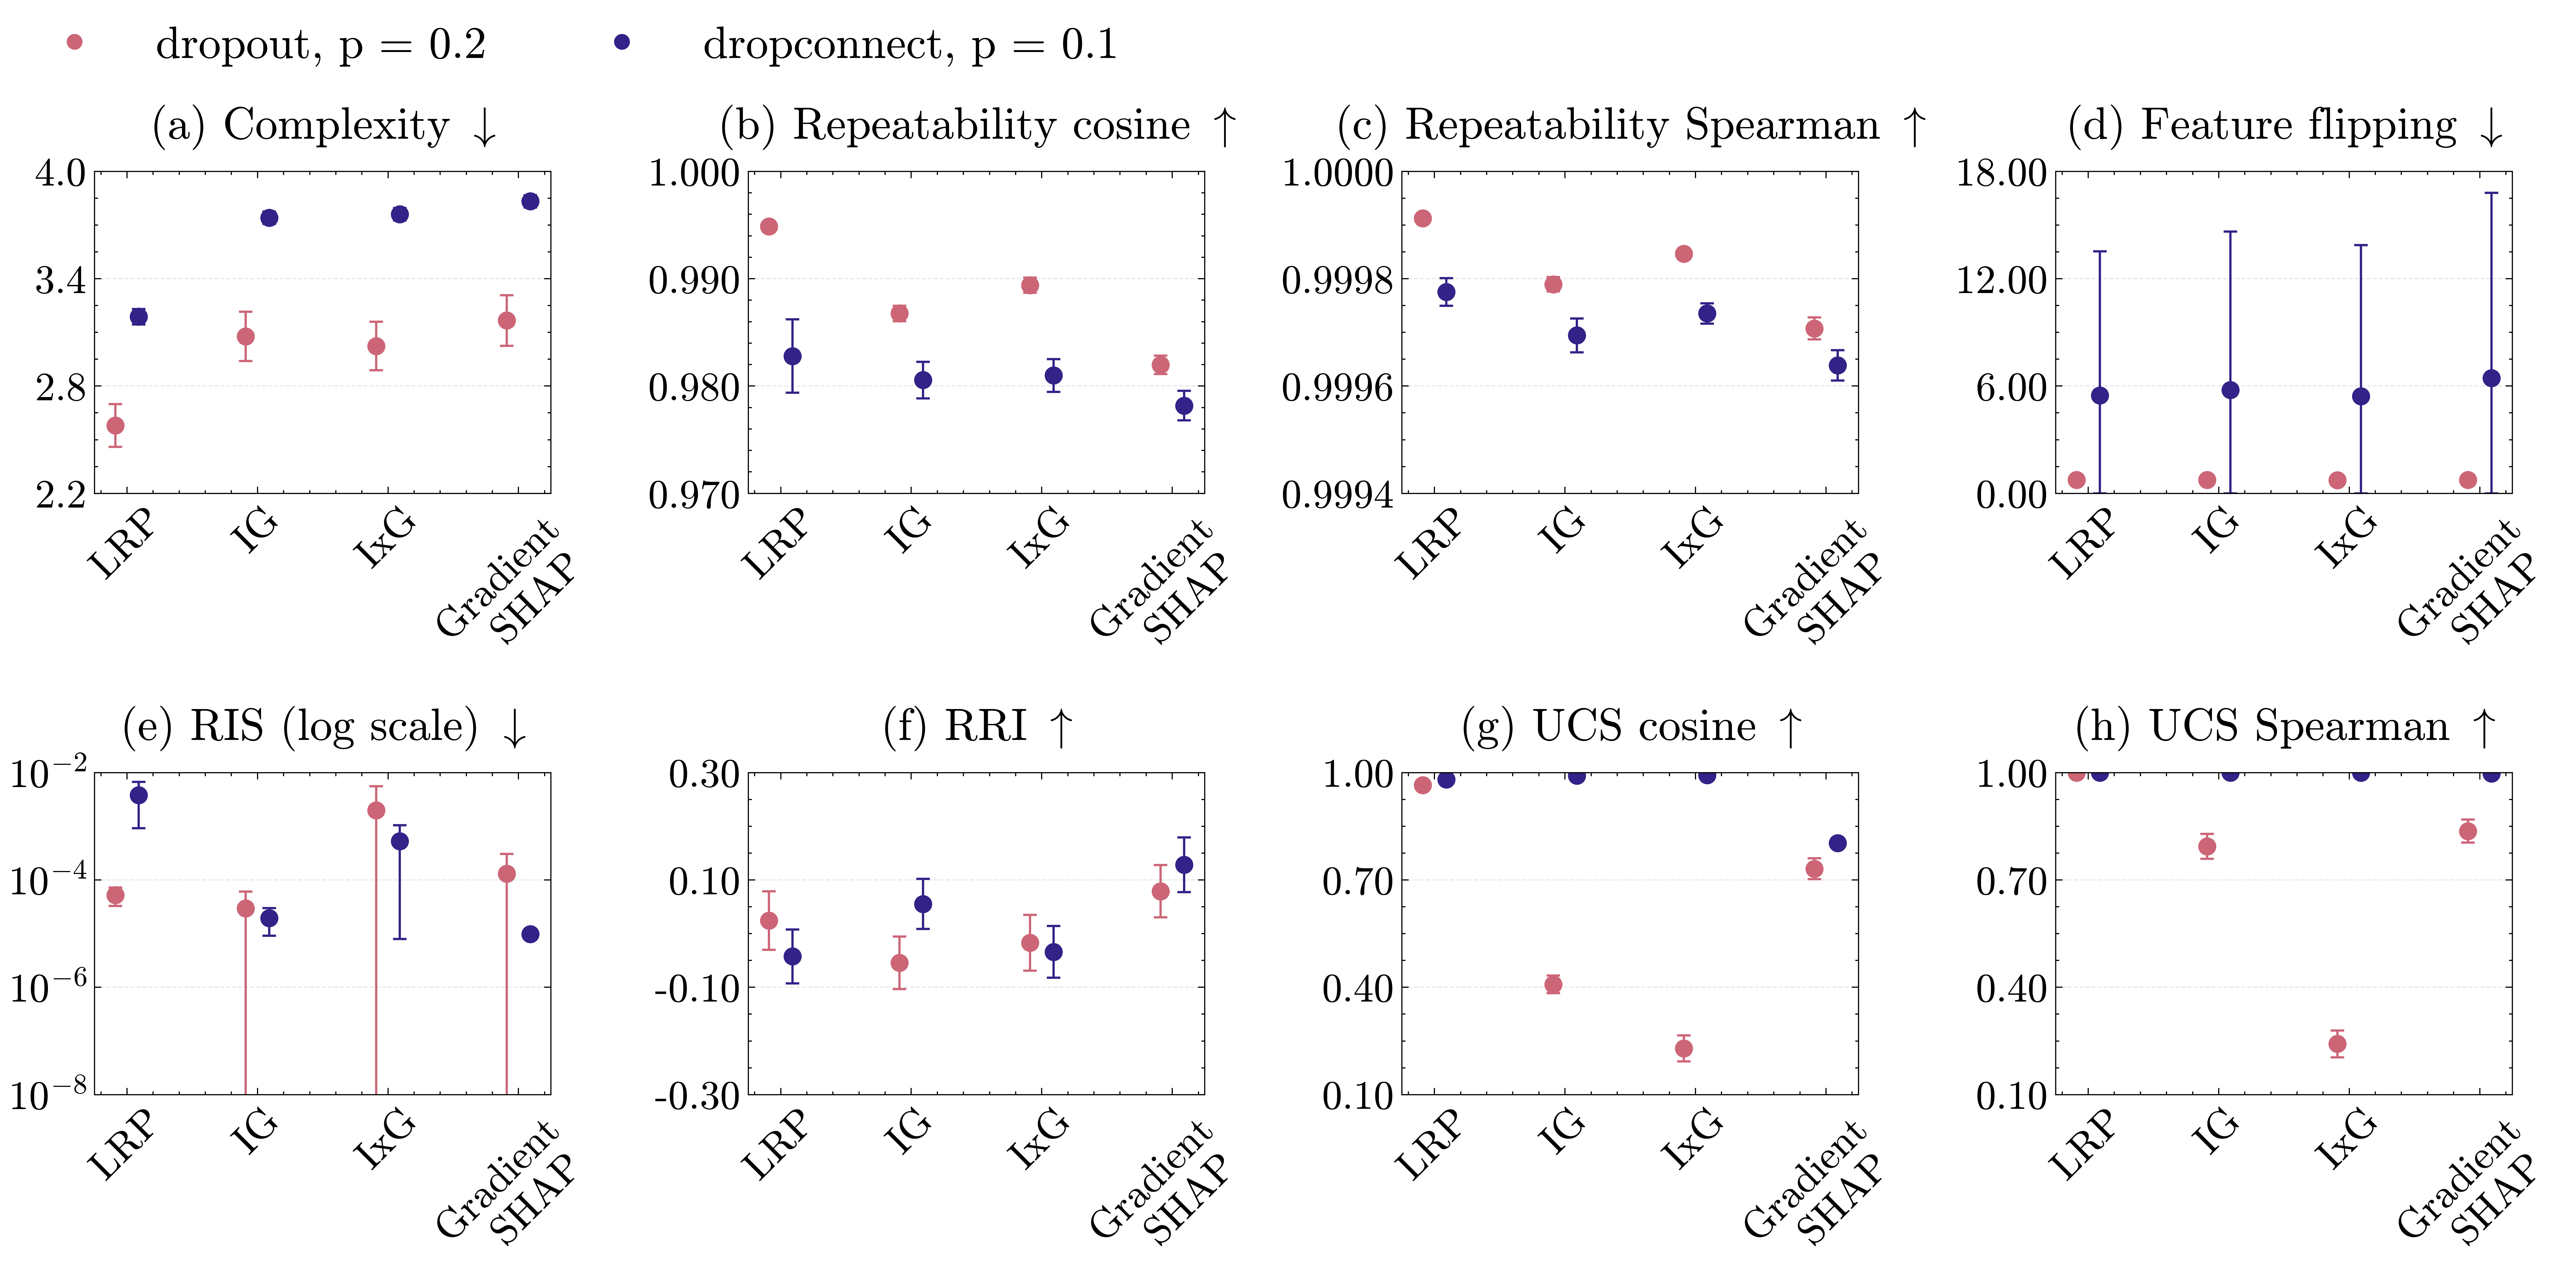

In [21]:
metrics_all_values = [("Complexity", complexity, "all_values", "lower"), ("Repeatability cosine", determinism, "all_values_cosine", "higher"), ("Repeatability Spearman", determinism, "all_values_spearman", "higher"), ("Feature flipping", featureflipping, "all_values", "lower"),
                      ("RIS", ris, "all_values", "lower"), ("RRI", rri, "rank_changes", "higher"), ("UCS cosine", ucs, "all_values_cosine", "higher"), ("UCS Spearman", ucs, "all_values_spearman", "higher")]
fig, axs = plot_metrics_dot_by_method_all_values(dicts, metrics_all_values, metric_names, nrows=2, ncols=4, figsize=(16, 8), title="")

fig.savefig("/workspaces/expainable-uncertainty-quantification/output/mnist_dotplots.pdf", dpi=300, bbox_inches="tight")

# Get average metric scores per uncertainty attribution method

In [22]:
metrics = [("Complexity", complexity, "mean", "lower"), ("Repeatability Cosine", determinism, "mean_cosine", "higher"), ("Repeatability Spearman", determinism, "mean_spearman", "higher"), ("Feature Flipping", featureflipping, "auc_mean", "lower"),
           ("RIS", ris, "RIS_mean", "lower"), ("RRI", rri, "avg_unc_rank_change", "higher"), ("UCS Cosine", ucs, "mean_cosine", "higher"), ("UCS Spearman", ucs, "mean_spearman", "higher")]
methods = ['Integrated Gradients', 'InputXGradient', 'Gradient SHAP', 'LRP']

for (name, data, key, _) in metrics:
    for xai_method in methods:
        list_val_dropout = data["dropout_02"][xai_method][key]
        list_val_dropconnect = data["dropconnect_01"][xai_method][key]
        mean_dropout = np.mean(list_val_dropout)
        mean_dropconnect = np.mean(list_val_dropconnect)
        mean_dropout = np.round(mean_dropout,3)
        mean_dropconnect = np.round(mean_dropconnect, 5)
        print(f"{name}: {xai_method} - dropout: {mean_dropout}, dropconnect: {mean_dropconnect}")


Complexity: Integrated Gradients - dropout: 3.078, dropconnect: 3.74076
Complexity: InputXGradient - dropout: 3.023, dropconnect: 3.76093
Complexity: Gradient SHAP - dropout: 3.166, dropconnect: 3.83263
Complexity: LRP - dropout: 2.58, dropconnect: 3.1878
Repeatability Cosine: Integrated Gradients - dropout: 0.987, dropconnect: 0.98056
Repeatability Cosine: InputXGradient - dropout: 0.989, dropconnect: 0.98098
Repeatability Cosine: Gradient SHAP - dropout: 0.982, dropconnect: 0.97818
Repeatability Cosine: LRP - dropout: 0.995, dropconnect: 0.9828
Repeatability Spearman: Integrated Gradients - dropout: 1.0, dropconnect: 0.99969
Repeatability Spearman: InputXGradient - dropout: 1.0, dropconnect: 0.99974
Repeatability Spearman: Gradient SHAP - dropout: 1.0, dropconnect: 0.99964
Repeatability Spearman: LRP - dropout: 1.0, dropconnect: 0.99978
Feature Flipping: Integrated Gradients - dropout: 0.75, dropconnect: 5.78067
Feature Flipping: InputXGradient - dropout: 0.742, dropconnect: 5.42949


# Sanity Checks

In [23]:
methods_list = ['Integrated Gradients', 'InputXGradient', 'Gradient SHAP', 'LRP']

In [ ]:
def get_inter_rater_method_reliability(key_to_use, methods, metric_name, data, uq_methods):
    """
    Returns: inter_method, inter_sample, standard deviation and coefficient of variation for one metric

    """
    methods_list = list(methods)
    all_methods_list = [f"{m}_{uq}" for uq in uq_methods for m in methods_list]

    arrays = []
    stds = []
    cvss = []
    for uq in uq_methods:
        for xai in methods_list:
            try:
                vals = np.concatenate(data[uq][xai][key_to_use])
                std = np.std(vals)
                mean = np.mean(vals)
                cvs = abs(std/(mean+1e-8))
            except Exception:
                try:
                    vals = data[uq][xai][key_to_use]
                except Exception:
                    vals = np.array([])
            arrays.append(np.asarray(vals))
            stds.append(std)
            cvss.append(cvs)
    std_avg = np.mean(stds)
    cvs_avg = np.mean(cvs)

    if not arrays or any(a.size == 0 for a in arrays):
        return np.nan, np.nan

    min_length = min(a.size for a in arrays)
    if min_length < 2:
        return np.nan, np.nan

    # data matrix: rows = samples, cols = methods
    data_matrix = np.vstack([a[:min_length] for a in arrays]).T 

    # invert sign for metrics where lower is better
    if metric_name in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix = -data_matrix

    # compute pairwise Spearman correlations between methods (columns)
    res_methods = spearmanr(data_matrix, axis=0)
    if isinstance(res_methods, tuple) and len(res_methods) == 2:
        corr_methods, _ = res_methods
    else:
        corr_methods = res_methods

    corr_methods = np.asarray(corr_methods, dtype=float)
    if corr_methods.ndim == 0:
        corr_val = float(corr_methods)
        corr_methods = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_methods.ndim == 1:
        s = corr_methods.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_methods = corr_methods.reshape((n, n))
        else:
            corr_methods = np.diag(corr_methods)

    n_methods = corr_methods.shape[0]
    if n_methods < 2:
        method_rhos = np.array([])
    else:
        iu = np.triu_indices(n_methods, k=1)
        method_rhos = corr_methods[iu]

    # compute pairwise Spearman correlations between samples (rows) 
    res_samples = spearmanr(data_matrix.T, axis=0)
    if isinstance(res_samples, tuple) and len(res_samples) == 2:
        corr_samples, _ = res_samples
    else:
        corr_samples = res_samples

    corr_samples = np.asarray(corr_samples, dtype=float)
    if corr_samples.ndim == 0:
        corr_val = float(corr_samples)
        corr_samples = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_samples.ndim == 1:
        s = corr_samples.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_samples = corr_samples.reshape((n, n))
        else:
            corr_samples = np.diag(corr_samples)

    n_samples = corr_samples.shape[0]
    if n_samples < 2:
        sample_rhos = np.array([])
    else:
        iu_s = np.triu_indices(n_samples, k=1)
        sample_rhos = corr_samples[iu_s]

    inter_method = np.nanmean(method_rhos) if method_rhos.size > 0 else np.nan
    inter_sample = np.nanmean(sample_rhos) if sample_rhos.size > 0 else np.nan

    return inter_method, inter_sample, std_avg, cvs_avg

: 

In [ ]:
metrics_all_values = [("Complexity", complexity, "all_values"), ("Repeatability Cosine", determinism, "all_values_cosine"), ("Repeatability Spearman", determinism, "all_values_spearman"), ("Feature Flipping", featureflipping, "all_values"),
                      ("RIS", ris, "all_values"), ("RRI", rri, "rank_changes"), ("UCS Cosine", ucs, "all_values_cosine"), ("UCS Spearman", ucs, "all_values_spearman")]

for (name, data, key) in metrics_all_values:
    inter_method, inter_sample,std, cvs = get_inter_rater_method_reliability(key, methods, metric_name = name, data = data, uq_methods = ["dropout_02","dropconnect_01"]) # type: ignore
    print(f"{name} - Inter-method reliability: {inter_method}, Inter-sample reliability: {inter_sample},  cvs: {cvs}")


Complexity - Inter-method reliability: 0.5708868955073712, Inter-sample reliability: 0.40759631693846354,  cvs: 0.15455992452171444
Repeatability Cosine - Inter-method reliability: 0.268054987648522, Inter-sample reliability: 0.31244809032907483,  cvs: 0.03957411318632308
Repeatability Spearman - Inter-method reliability: 0.7543205761394474, Inter-sample reliability: 0.47967247401143537,  cvs: 0.00029176085180711113
Feature Flipping - Inter-method reliability: 0.02876048761337902, Inter-sample reliability: 0.20394388777555114,  cvs: 16.769737536281287
RIS - Inter-method reliability: 0.388939278745283, Inter-sample reliability: 0.41968589426055003,  cvs: 8.632775094244586


In [ ]:
def get_inter_rater_method_reliability_pairs(key_to_use, methods, metric_name, data, uq_methods):
    """
    Returns pairwise Spearman correlations for:
      - all pairs of methods (columns) -> method_pairs, method_rhos
      - all pairs of samples (rows) -> sample_pairs, sample_rhos
    Also returns average std and average coeff-of-variation across flattened arrays.

    """
    methods_list = list(methods)
    all_methods_list = [f"{m}_{uq}" for uq in uq_methods for m in methods_list]

    arrays = []
    stds = []
    cvss = []
    for uq in uq_methods:
        for xai in methods_list:
            std = np.nan
            cvs = np.nan
            try:
                vals = np.concatenate(data[uq][xai][key_to_use])
                std = float(np.std(vals))
                mean = float(np.mean(vals))
                cvs = abs(std / (mean + 1e-8))
            except Exception:
                try:
                    vals = data[uq][xai][key_to_use]
                except Exception:
                    vals = np.array([])
            arrays.append(np.asarray(vals))
            stds.append(std)
            cvss.append(cvs)

    std_avg = float(np.nanmean(stds)) if stds else np.nan
    cvs_avg = float(np.nanmean(cvss)) if cvss else np.nan

    if not arrays or any(a.size == 0 for a in arrays):
        return [], np.array([]), [], np.array([]), std_avg, cvs_avg

    min_length = min(a.size for a in arrays)
    if min_length < 2:
        return [], np.array([]), [], np.array([]), std_avg, cvs_avg

    # data matrix: rows = samples, cols = methods
    data_matrix = np.vstack([a[:min_length] for a in arrays]).T  

    # invert sign for metrics where lower is better
    if metric_name in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix = -data_matrix

    # compute pairwise Spearman correlations between methods (columns)
    res_methods = spearmanr(data_matrix, axis=0)
    if isinstance(res_methods, tuple) and len(res_methods) == 2:
        corr_methods, _ = res_methods
    else:
        corr_methods = res_methods

    corr_methods = np.asarray(corr_methods, dtype=float)
    if corr_methods.ndim == 0:
        corr_val = float(corr_methods)
        corr_methods = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_methods.ndim == 1:
        s = corr_methods.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_methods = corr_methods.reshape((n, n))
        else:
            corr_methods = np.diag(corr_methods)

    n_methods = corr_methods.shape[0]
    if n_methods < 2:
        method_rhos = np.array([])
        method_pairs = []
    else:
        iu = np.triu_indices(n_methods, k=1)
        method_rhos = corr_methods[iu]
        method_pairs = [(all_methods_list[i], all_methods_list[j]) for i, j in zip(iu[0], iu[1])]

    # compute pairwise Spearman correlations between samples (rows) 
    res_samples = spearmanr(data_matrix.T, axis=0)
    if isinstance(res_samples, tuple) and len(res_samples) == 2:
        corr_samples, _ = res_samples
    else:
        corr_samples = res_samples

    corr_samples = np.asarray(corr_samples, dtype=float)
    if corr_samples.ndim == 0:
        corr_val = float(corr_samples)
        corr_samples = np.array([[1.0, corr_val], [corr_val, 1.0]])
    elif corr_samples.ndim == 1:
        s = corr_samples.size
        n = int(np.sqrt(s))
        if n * n == s:
            corr_samples = corr_samples.reshape((n, n))
        else:
            corr_samples = np.diag(corr_samples)

    n_samples = corr_samples.shape[0]
    if n_samples < 2:
        sample_rhos = np.array([])
        sample_pairs = []
    else:
        iu_s = np.triu_indices(n_samples, k=1)
        sample_rhos = corr_samples[iu_s]
        sample_pairs = [(int(i), int(j)) for i, j in zip(iu_s[0], iu_s[1])]

    return method_pairs, method_rhos, sample_rhos, std_avg, cvs_avg

In [ ]:
def get_internal_consistency(key_1, data_1, key_2, data_2, methods, uq_methods, metric_name_1, metric_name_2):
    methods_list = list(methods)
    all_methods_list = [f"{m}_{uq}" for uq in uq_methods for m in methods_list]

    arrays_1 = []
    arrays_2 = []
    stds = []
    cvss = []
    for uq in uq_methods:
        for xai in methods_list:
            std = np.nan
            cvs = np.nan
            try:
                vals_1 = np.concatenate(data_1[uq][xai][key_1])
                vals_2 = np.concatenate(data_2[uq][xai][key_2])
                std = float(np.std(vals_1))
                mean = float(np.mean(vals_1))
                cvs = abs(std / (mean + 1e-8))
            except Exception:
                # fallback: try to use as-is or empty array
                try:
                    vals_1 = data_1[uq][xai][key_1]
                    vals_2 = data_2[uq][xai][key_2]
                except Exception:
                    vals_1 = np.array([])
                    vals_2 = np.array([])
            arrays_1.append(np.asarray(vals_1))
            arrays_2.append(np.asarray(vals_2))
            stds.append(std)
            cvss.append(cvs)

    std_avg = float(np.nanmean(stds)) if stds else np.nan
    cvs_avg = float(np.nanmean(cvss)) if cvss else np.nan

    if not arrays_1 or any(a.size == 0 for a in arrays_1) or not arrays_2 or any(a.size == 0 for a in arrays_2):
        return np.nan, [], np.array([]), std_avg, cvs_avg

    min_length = min(a.size for a in arrays_1 + arrays_2)
    if min_length < 2:
        return np.nan, [], np.array([]), std_avg, cvs_avg

    # data matrix: rows = samples, cols = methods
    data_matrix_1 = np.vstack([a[:min_length] for a in arrays_1]).T 
    data_matrix_2 = np.vstack([a[:min_length] for a in arrays_2]).T 

    # invert sign for metrics where lower is better
    if metric_name_1 in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix_1 = -data_matrix_1
    if metric_name_2 in ["Complexity", "Feature Flipping", "RIS"]:
        data_matrix_2 = -data_matrix_2

    method_rhos = []
    method_pvals = []
    method_names = all_methods_list[: data_matrix_1.shape[1]]

    for col in range(data_matrix_1.shape[1]):
        col1 = data_matrix_1[:, col]
        col2 = data_matrix_2[:, col]
        mask = ~np.isnan(col1) & ~np.isnan(col2)
        col1_clean = col1[mask]
        col2_clean = col2[mask]
        if col1_clean.size < 2:
            rho = np.nan
            p = np.nan
        else:
            try:
                rho, p = spearmanr(col1_clean, col2_clean)
                if isinstance(rho, np.ndarray):
                    rho = float(rho)
                if isinstance(p, np.ndarray):
                    p = float(p)
            except Exception:
                rho = np.nan
                p = np.nan
        method_rhos.append(float(rho) if not pd.isna(rho) else np.nan) # type: ignore
        method_pvals.append(float(p) if not pd.isna(p) else np.nan) # type: ignore

    method_rhos = np.asarray(method_rhos, dtype=float)
    method_pvals = np.asarray(method_pvals, dtype=float)

    overall_mean_rho = float(np.nanmean(method_rhos)) if method_rhos.size > 0 else np.nan

    per_method_results = list(zip(method_names, method_rhos.tolist(), method_pvals.tolist()))

    return overall_mean_rho, per_method_results, method_rhos, std_avg, cvs_avg


In [ ]:
metrics_all_values = [ ("Repeatability Cosine", determinism, "all_values_cosine"), ("Repeatability Spearman", determinism, "all_values_spearman"),
                      ("RRI", rri, "rank_changes"), ("UCS Cosine", ucs, "all_values_cosine"), ("UCS Spearman", ucs, "all_values_spearman")]
pairs_to_check = [("RRI", "UCS Cosine"), ("RRI", "UCS Spearman")]
methods = ["LRP","Integrated Gradients", "InputXGradient", "Gradient SHAP"]
for i in range(len(metrics_all_values)):
    for j in range(i+1, len(metrics_all_values)):
        pair_names = (metrics_all_values[i][0], metrics_all_values[j][0])
        if pair_names not in pairs_to_check and (pair_names[1], pair_names[0]) not in pairs_to_check:
            continue
        (name_1, data_1, key_1) = metrics_all_values[i]
        (name_2, data_2, key_2) = metrics_all_values[j]
        overall_mean_rho, per_method_results, method_rhos, std_avg, cvs_avg = get_internal_consistency(key_1, data_1, key_2, data_2, methods, metric_name_1=name_1, metric_name_2=name_2, uq_methods = ["dropout_02", "dropconnect_01"])
        print(f"Internal consistency between {name_1} and {name_2} - Overall mean Spearman rho: {overall_mean_rho}, std: {std_avg}, cvs: {cvs_avg}")
        print("Per-method results:")    
        for method_name, rho, p in per_method_results:
            print(f"  {method_name}: rho={rho}, p-value={p}")
        

Internal consistency between RRI and UCS Cosine - Overall mean Spearman rho: 0.010765814230457178, std: 2.851107616437946, cvs: 75.71119767319016
Per-method results:
  LRP_dropout_02: rho=0.05129050359444109, p-value=0.25230295646408907
  Integrated Gradients_dropout_02: rho=0.009523509484857062, p-value=0.8317762874560859
  InputXGradient_dropout_02: rho=0.06923592697707202, p-value=0.12206995442374251
  Gradient SHAP_dropout_02: rho=-0.07161764326711142, p-value=0.1097172316606616
  LRP_dropconnect_01: rho=-0.03232392624161075, p-value=0.4708083827828181
  Integrated Gradients_dropconnect_01: rho=0.03988168239821082, p-value=0.37351765701391504
  InputXGradient_dropconnect_01: rho=0.02234115840445436, p-value=0.6182195085553202
  Gradient SHAP_dropconnect_01: rho=-0.0022046975066557562, p-value=0.9607796698225237
Internal consistency between RRI and UCS Spearman - Overall mean Spearman rho: 0.023407444926100408, std: 2.851107616437946, cvs: 75.71119767319016
Per-method results:
  LRP